In [1]:
# base environment
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm
import math
import re;
import os;


from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,roc_auc_score,f1_score

In [2]:
#s=pd.read_csv(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\ch_dia_es_to_csv_300.csv").head(10000)
#s.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\sample.xlsx")
s=pd.read_csv(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\ch_lab_es_to_csv_300.csv").head(10000)
s.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\sample_item.xlsx")

### 处理诊断数据，找出患有结肠疾病的患者

In [3]:
dia_1=pd.read_csv(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\ch_dia_es_to_csv_300.csv",index_col=0)
dia_2=pd.read_csv(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\ch_dia_es_to_csv_519.csv",index_col=0)

C:\Users\Wu Zihao\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
dia=pd.merge(dia_1,dia_2,how="outer")

In [5]:
str_dig=dia['诊断'].apply(str)
dia["诊断"]=str_dig

In [6]:
dia

,患者ID,性别,年龄,诊断,诊断日期
0,06516768,男,20.0,幽门螺旋杆菌感染,2020-09-22 00:00:00
1,06408054,女,73.0,左膝关节单髁置换术后,2020-09-22 00:00:00
2,5004648126,女,37.0,月经淋漓不尽,2020-09-22 00:00:00
3,5004648126,女,37.0,宫内节育器(IUD),2020-09-22 00:00:00
4,K23054402,女,43.0,鼻咽部异物,2020-09-22 00:00:00
...,...,...,...,...,...
5184102,QG00004422,男,69.0,脑梗死,2020-03-25 00:00:00
5184103,QG00004422,男,69.0,肺部感染,2020-03-25 00:00:00
5184104,QG00004422,男,69.0,高血压I期,2020-03-25 00:00:00
5184105,QG00004422,男,69.0,2型糖尿病,2020-03-25 00:00:00


In [7]:
related_dig = dia.copy()
related_dig = related_dig[related_dig["诊断"].str.contains("结肠|直肠")]
related_dig.reset_index(inplace=True)

In [328]:
dia["诊断"].str.contains("健康").sum()

15645

In [8]:
not_valid=related_dig["诊断"].str.contains("术后")
valid = [not i for i in not_valid]
not_valid

0         False
1         False
2          True
3         False
4         False
          ...  
121085    False
121086    False
121087    False
121088    False
121089    False
Name: 诊断, Length: 121090, dtype: bool

### Add healthy patient if necessary

In [204]:
add_health = dia.copy()
add_health = add_health[add_health["诊断"].str.contains("健康")]
add_health.reset_index(inplace=True)
add_health.drop("index",axis=1,inplace=True)

health_ID = [];
for i in tqdm(add_health.index):
    if add_health["患者ID"].loc[i] in health_ID:
        add_health.drop(i,axis=0,inplace=True)
    else:
        health_ID.append(add_health["患者ID"].loc[i])
        
add_health.reset_index(inplace=True)
add_health.drop("index",axis=1,inplace=True)     


health_data = pd.DataFrame(columns= feature_Chinese)
health_data.insert(column="患者ID",loc=0,value=add_health["患者ID"])
health_data.insert(column="癌",loc=len(health_data.columns),value=add_health["诊断"])


selected_table=os.listdir(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data")
health_list=list(add_health["患者ID"])
for i in range(len(selected_table)):
    selected_table[i]=os.path.join(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data",selected_table[i])
    
for in_path in tqdm(selected_table[2:]):
    data = pd.read_csv(in_path,engine='python');
    ID_list = list(data["患者ID"])
    name_list = list(data["检验名"])
    result_list = list(data["结果"])
    
    
    for i in tqdm(data.index): #data.index
        current_ID = ID_list[i]#data["患者ID"].loc[i]
        name = name_list[i] #data["检验名"].loc[i]
        if current_ID in health_ID and name in feature_Chinese:
            #row_index = std_data[std_data["患者ID"] == current_ID].index.tolist()[0] #找出对应的row index
            #row_index = std_data[std_data["患者ID"] == current_ID].index.tolist()[0] #找出对应的row index
            row_index = health_list.index(current_ID)
            health_data[name].loc[row_index] = result_list[i]#data["结果"].loc[i]
        
health_data



  0%|          | 0/15645 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/2346172 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,06158794,11.9,阴性,阴性,301,32.7,NaN,10.80,4.1,1.69,6.8,44,无,1.6,70,NaN,7.3,144,无,健康查体
1,J19393295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,健康查体
2,01748140,12.9,阴性,阴性,279,37.9,NaN,11.70,3.7,2.30,2.9,46,5.91,1.8,66,NaN,6.2,138,3.86,健康查体
3,06480777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,健康查体
4,QG00055641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,健康查体
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,06381322,11.9,NaN,NaN,NaN,26.7,NaN,10.20,NaN,NaN,NaN,NaN,5.00,2.2,NaN,NaN,9.4,NaN,4.06,健康查体
6266,06380882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,健康查体
6267,05240068,NaN,NaN,NaN,274,NaN,NaN,NaN,NaN,2.17,2.5,50,NaN,NaN,73,NaN,NaN,NaN,NaN,健康查体
6268,L03046701,12.5,NaN,NaN,NaN,11.0,NaN,8.00,NaN,NaN,NaN,NaN,5.57,3.0,NaN,NaN,7.6,NaN,6.58,健康查体


In [239]:
health_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\health_data.xlsx")

In [9]:
### 去除"结肠癌术后"
related_dig=dia[dia["诊断"].str.contains("肠")]
#for i in tqdm(related_dig.index):
    #if related_dig["诊断"].loc[i].str.contains("结肠癌术后"):
        #related_dig.drop(i,axis=0,inplace=True)

not_valid = related_dig["诊断"].str.contains("术后")
valid = [not i for i in not_valid]
        
related_dig=related_dig[valid]
        
related_dig.reset_index(inplace=True)
related_dig.drop("index",axis=1,inplace=True)

In [10]:
### 去除重复项诊断
ID = [];
for i in tqdm(related_dig.index):
    if related_dig["患者ID"].loc[i] in ID:
         related_dig.drop(i,axis=0,inplace=True)
    else:
        ID.append(related_dig["患者ID"].loc[i])
        
related_dig.reset_index(inplace=True)
related_dig.drop("index",axis=1,inplace=True)      

  0%|          | 0/164163 [00:00<?, ?it/s]

In [11]:
(related_dig["诊断"]=="结肠癌").sum()/(related_dig["诊断"]=="结肠癌").count()

0.009649522075557578

In [12]:
ID = []
for i in related_dig.index:
    ID.append(related_dig["患者ID"].loc[i])

In [330]:
len(ID)+15645

81555

In [441]:
related_dig.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\预测集\dignosis_data.xlsx")

In [442]:
related_dig = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\预测集\dignosis_data.xlsx",index_col=0)

In [443]:
related_dig

,患者ID,性别,年龄,诊断,诊断日期
0,06415063,男,44.0,回肠造口维护,2020-09-22 00:00:00
1,06485718,男,51.0,直肠癌,2020-09-22 00:00:00
2,M01792599,男,65.0,回肠造口维护,2020-09-22 00:00:00
3,2605010003,男,94.0,胃肠炎,2020-09-22 00:00:00
4,06516527,男,47.0,结肠炎,2020-09-22 00:00:00
...,...,...,...,...,...
65905,QG00000481,男,79.0,肠梗阻,2020-03-30 00:00:00
65906,K06495281,男,65.0,溃疡性结肠炎,2020-03-25 00:00:00
65907,06365826,男,40.0,胃肠道间质性瘤，潜在恶性未肯定,2020-03-30 00:00:00
65908,QG00041548,男,48.0,恶性胃肠道间质性瘤,2020-03-23 00:00:00


### Find the corresponding item

In [29]:
s=pd.read_csv(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data\ch_lab_es_to_csv_300.csv",index_col=0)

C:\Users\Wu Zihao\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [27]:
useful_item= ['RDW',
 'FIT positive',
 "Fecal transferrin's data is missing'",
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'MPV',
 'K+',
 'A/G',
 'TBA',
 'Fecal transferrin positive',
 'ALB',
 'RBC',
 'Eos%',
 'TP',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [193]:
unit = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\feature name and unit.xlsx")
feature_Chinese = ["红细胞分布宽度","隐血","转铁蛋白","前白蛋白","大血小板细胞比率","年龄","平均血小板体积","钾","白蛋白/球蛋白","总胆汁酸",
                  "白蛋白","红细胞计数","嗜酸性粒细胞百分比","总蛋白","性别","单核细胞百分比","钠","白细胞计数"]

In [124]:
s

,患者ID,性别,年龄,检验名,标本,结果,参考值,单位,报告时间
0,05659692,男,49.0,血小板压积,血,0.23,"[0.16,0.35]",%,2020-01-18 09:34:22
1,K21889211,男,63.0,梅毒螺旋体抗体,血,阴性,"{'阴性','-'}",NaN,2020-01-16 11:10:33
2,K21889211,男,63.0,丙型肝炎病毒抗体.IgG[化学发光法],血,阴性,"{'阴性','-'}",NaN,2020-01-16 11:10:33
3,05659692,男,49.0,凝血酶原时间,血,14.0,"[11,14.3]",s,2020-01-18 10:05:38
4,05659692,男,49.0,凝血酶原时间国际标准化比值,血,1.08,"[0.9,1.1]",NaN,2020-01-18 10:05:38
...,...,...,...,...,...,...,...,...,...
2999995,JR1046787,男,28.0,红细胞比容,血,0.43,"[0.40,0.50]",L/L,2020-09-11 22:53:02
2999996,QG00053524,男,67.0,大血小板细胞比率,血,21.1,"[19.2,47]",%,2020-09-10 07:22:29
2999997,JR1046787,男,28.0,平均红细胞血红蛋白含量,血,30.7,"[27,34]",pg,2020-09-11 22:53:02
2999998,06414245,女,58.0,直接胆红素,血,4.0,"[0,7)",umol/L,2020-09-10 08:46:35


In [444]:
std_data = pd.DataFrame(columns= feature_Chinese)
std_data.insert(column="患者ID",loc=0,value=related_dig["患者ID"])
std_data.insert(column="癌",loc=len(std_data.columns),value=related_dig["诊断"])
std_data

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,06415063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,回肠造口维护
1,06485718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,直肠癌
2,M01792599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,回肠造口维护
3,2605010003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,胃肠炎
4,06516527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,结肠炎
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65905,QG00000481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,肠梗阻
65906,K06495281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,溃疡性结肠炎
65907,06365826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,胃肠道间质性瘤，潜在恶性未肯定
65908,QG00041548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,恶性胃肠道间质性瘤


In [445]:
selected_table=os.listdir(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data")
for i in range(len(selected_table)):
    selected_table[i]=os.path.join(r"D:\HKUST\Program\结肠癌分类器\终稿\New Data",selected_table[i])
    
for in_path in tqdm(selected_table[2:]):
    data = pd.read_csv(in_path,engine='python');
    ID_list = list(data["患者ID"])
    name_list = list(data["检验名"])
    result_list = list(data["结果"])
    
    
    for i in tqdm(data.index): #data.index
        current_ID = ID_list[i]#data["患者ID"].loc[i]
        name = name_list[i] #data["检验名"].loc[i]
        if current_ID in ID and name in feature_Chinese:
            #row_index = std_data[std_data["患者ID"] == current_ID].index.tolist()[0] #找出对应的row index
            #row_index = std_data[std_data["患者ID"] == current_ID].index.tolist()[0] #找出对应的row index
            row_index = concerned_list.index(current_ID)
            std_data[name].loc[row_index] = result_list[i]#data["结果"].loc[i]
        
std_data

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/2346172 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,06415063,15.6,阴性,阴性,239,27.5,NaN,10.50,4.2,1.47,1.6,47,4.61,1.0,79,NaN,10.9,139,3.94,回肠造口维护
1,06485718,13.7,++,NaN,262,11.9,NaN,8.50,4.4,1.55,2.5,45,4.20,0.8,74,NaN,7.2,140,8.24,直肠癌
2,M01792599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,回肠造口维护
3,2605010003,12.9,NaN,NaN,179,19.5,NaN,9.30,4.2,1.32,2.2,40,4.07,3.4,51,NaN,8.0,141,7.12,胃肠炎
4,06516527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,结肠炎
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65905,QG00000481,14.8,++,阴性,112,21.3,NaN,9.60,4.1,1.57,9.7,39,3.44,0.5,59,NaN,7.7,141,0.60,肠梗阻
65906,K06495281,12.6,阴性,阴性,249,26.1,NaN,10.10,3.7,1.40,2.6,42,5.05,3.5,72,NaN,10.6,144,10.80,溃疡性结肠炎
65907,06365826,12.5,阴性,阴性,143,46.9,NaN,12.60,3.35,1.76,1.5,37,无,2.7,58,NaN,8.0,140.90,13.52,胃肠道间质性瘤，潜在恶性未肯定
65908,QG00041548,20.5,阴性,阴性,170,31.7,NaN,10.70,4.8,1.35,15.7,42,无,1.1,73,NaN,9.1,143,无,恶性胃肠道间质性瘤


In [446]:
std_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\std_data1.xlsx")

In [396]:
#std_data = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\std_data1.xlsx",index_col=0)
std_data = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\Attempt2\std_data1.xlsx",index_col=0)

In [398]:
health_data=pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\Attempt4\health_data.xlsx",index_col=0)
health_data["大血小板细胞比率"]=health_data["大血小板细胞比率"].astype("object")

In [399]:
std_data = pd.merge(std_data,health_data,how="outer")

In [400]:
### Add “年龄”and “性别”
for i in tqdm(std_data.index):
    current_ID = std_data["患者ID"].loc[i]
    
    try:
        row_index = related_dig[related_dig["患者ID"] == current_ID].index.tolist()[0]
        std_data["年龄"].loc[i] = related_dig["年龄"].loc[row_index]
    
        if related_dig["性别"].loc[row_index] == "男":
            std_data["性别"].loc[i] = 1
        elif related_dig["性别"].loc[row_index] == "女":
            std_data["性别"].loc[i] = 0
        else:
            std_data["性别"].loc[i] = np.nan
    except:
        row_index = add_health[add_health["患者ID"] == current_ID].index.tolist()[0]
        std_data["年龄"].loc[i] = add_health["年龄"].loc[row_index]
    
        if add_health["性别"].loc[row_index] == "男":
            std_data["性别"].loc[i] = 1
        elif add_health["性别"].loc[row_index] == "女":
            std_data["性别"].loc[i] = 0
        else:
            std_data["性别"].loc[i] = np.nan

  0%|          | 0/24606 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [401]:
std_data

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,06516527,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,结肠炎
1,04936166,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,溃疡性结肠炎
2,QG00028959,13.0,±,弱阳性,228.0,25.0,73.0,10.0,3.9,1.44,4.1,46.0,4.64,2.3,78.0,1.0,10.1,142.0,3.95,结肠造口维护
3,M03378199,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,溃疡性结肠炎
4,06421965,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,结肠息肉
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24601,06381322,11.9,NaN,NaN,NaN,26.7,54.0,10.2,NaN,NaN,NaN,NaN,5.00,2.2,NaN,1.0,9.4,NaN,4.06,健康查体
24602,06380882,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,健康查体
24603,05240068,NaN,NaN,NaN,274.0,NaN,48.0,NaN,NaN,2.17,2.5,50.0,NaN,NaN,73.0,1.0,NaN,NaN,NaN,健康查体
24604,L03046701,12.5,NaN,NaN,NaN,11.0,38.0,8.0,NaN,NaN,NaN,NaN,5.57,3.0,NaN,1.0,7.6,NaN,6.58,健康查体


In [402]:
### Save and drop the patients that does not have enough tests.
#CRC = std_data["癌"].str.contains("癌" or "恶性肿瘤").astype("int")
for i in tqdm(std_data.index):
    if str(std_data["隐血"].loc[i])=="nan":
        if std_data.loc[i].count()< 8: #and (not CRC[i]):
            std_data.drop(i,axis=0,inplace=True)
    else:
        if std_data.loc[i].count()< 16: #and (not CRC[i]):
            std_data.drop(i,axis=0,inplace=True)
std_data.reset_index(inplace=True)
std_data.drop("index",axis=1,inplace=True)

  0%|          | 0/24606 [00:00<?, ?it/s]

In [403]:
std_data

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,QG00028959,13.0,±,弱阳性,228.0,25.0,73.0,10.0,3.9,1.44,4.1,46.0,4.64,2.3,78.0,1.0,10.1,142.0,3.95,结肠造口维护
1,J06247272,21.6,NaN,NaN,62.0,20.1,62.0,9.5,3.2,1.28,15.4,31.0,1.15,0.1,57.0,0.0,5.3,133.0,10.77,结肠造口维护
2,6001008217,11.7,+++,NaN,NaN,19.8,58.0,9.3,3.7,1.24,NaN,41.0,满视野,0.0,74.0,0.0,2.9,138.0,"[5,10]",溃疡性结肠炎
3,H02768754,16.1,++,阳性,186.0,32.4,71.0,10.8,4.5,1.21,3.1,34.0,"[5,10]",1.6,62.0,0.0,9.0,134.0,无,乙状结肠癌
4,V01081223,13.0,NaN,NaN,NaN,18.6,57.0,9.2,NaN,NaN,NaN,NaN,4.59,0.7,NaN,0.0,5.6,NaN,5.87,慢性结肠炎
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,V09455349,13.4,NaN,NaN,NaN,17.3,25.0,9.1,NaN,NaN,NaN,NaN,5.90,2.1,NaN,1.0,6.5,NaN,9.14,健康查体
12150,06381322,11.9,NaN,NaN,NaN,26.7,54.0,10.2,NaN,NaN,NaN,NaN,5.00,2.2,NaN,1.0,9.4,NaN,4.06,健康查体
12151,05240068,NaN,NaN,NaN,274.0,NaN,48.0,NaN,NaN,2.17,2.5,50.0,NaN,NaN,73.0,1.0,NaN,NaN,NaN,健康查体
12152,L03046701,12.5,NaN,NaN,NaN,11.0,38.0,8.0,NaN,NaN,NaN,NaN,5.57,3.0,NaN,1.0,7.6,NaN,6.58,健康查体


In [290]:
### Additional step 
# Cut down some samples that have not being tested FIT
"""
for i in tqdm(std_data.index):
    if str(std_data["隐血"].loc[i])=="nan":
        if np.random.rand()> 0.5:
            std_data.drop(i,axis=0,inplace=True)

std_data.reset_index(inplace=True)
std_data.drop("index",axis=1,inplace=True)
"""

'\nfor i in tqdm(std_data.index):\n    if str(std_data["隐血"].loc[i])=="nan":\n        if np.random.rand()> 0.5:\n            std_data.drop(i,axis=0,inplace=True)\n\nstd_data.reset_index(inplace=True)\nstd_data.drop("index",axis=1,inplace=True)\n'

In [291]:
std_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\预测集\std2.xlsx")

In [292]:
### non-binary features: float, then fill in with mean value.
def tran_float(x):
    try:
        return float(x)
    except:
        return np.nan 

for i in tqdm(std_data.columns):
    if i not in ["隐血","转铁蛋白","癌","患者ID"]:
        std_data[i]=std_data[i].apply(tran_float)
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [293]:
for j in tqdm(std_data.columns):
    if j not in ["隐血","转铁蛋白","癌","患者ID"]:
        mean = std_data[j].mean()
        for i in tqdm(std_data.index):
            if math.isnan(std_data[j].loc[i]):
                std_data[j].loc[i] = mean

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

In [294]:
std_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\std_data2.xlsx")

In [295]:
chosen_data = std_data.copy()
chosen_data

,患者ID,红细胞分布宽度,隐血,转铁蛋白,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,QG00028959,13.000000,±,弱阳性,228.000000,25.000000,73.0,10.000000,3.900000,1.440000,4.100000,46.000000,4.640000,2.300000,78.000000,1.0,10.100000,142.000000,3.95000,结肠造口维护
1,J06247272,21.600000,NaN,NaN,62.000000,20.100000,62.0,9.500000,3.200000,1.280000,15.400000,31.000000,1.150000,0.100000,57.000000,0.0,5.300000,133.000000,10.77000,结肠造口维护
2,6001008217,11.700000,+++,NaN,222.384534,19.800000,58.0,9.300000,3.700000,1.240000,5.661933,41.000000,5.076332,0.000000,74.000000,0.0,2.900000,138.000000,9.20293,溃疡性结肠炎
3,H02768754,16.100000,++,阳性,186.000000,32.400000,71.0,10.800000,4.500000,1.210000,3.100000,34.000000,5.076332,1.600000,62.000000,0.0,9.000000,134.000000,9.20293,乙状结肠癌
4,V01081223,13.000000,NaN,NaN,222.384534,18.600000,57.0,9.200000,4.013646,1.617116,5.661933,42.036999,4.590000,0.700000,68.537227,0.0,5.600000,141.482158,5.87000,慢性结肠炎
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,V09455349,13.400000,NaN,NaN,222.384534,17.300000,25.0,9.100000,4.013646,1.617116,5.661933,42.036999,5.900000,2.100000,68.537227,1.0,6.500000,141.482158,9.14000,健康查体
12150,06381322,11.900000,NaN,NaN,222.384534,26.700000,54.0,10.200000,4.013646,1.617116,5.661933,42.036999,5.000000,2.200000,68.537227,1.0,9.400000,141.482158,4.06000,健康查体
12151,05240068,13.269665,NaN,NaN,274.000000,29.852382,48.0,10.568522,4.013646,2.170000,2.500000,50.000000,5.076332,2.202596,73.000000,1.0,7.775449,141.482158,9.20293,健康查体
12152,L03046701,12.500000,NaN,NaN,222.384534,11.000000,38.0,8.000000,4.013646,1.617116,5.661933,42.036999,5.570000,3.000000,68.537227,1.0,7.600000,141.482158,6.58000,健康查体


In [296]:
### binary features: seperate to two extended features
binary_list = ["隐血","转铁蛋白"]

for i in tqdm(chosen_data.columns):
    if i in binary_list:
        input_index=[column for column in chosen_data].index(i)#找到某个binary列名对应的索引
        
        chosen_data.insert(loc=input_index+1,column=i+"异常",value=0)
        chosen_data.insert(loc=input_index+2,column=i+"数据缺失",value=0)
        
        for j in tqdm(chosen_data.index):
            if chosen_data[i].loc[j] in ["正常","阴性","NEG","-"," -","软","黄色"]:
                chosen_data[i+"数据缺失"].loc[j] = 0
                chosen_data[i+"异常"].loc[j] = 0
            else: 
                if str(chosen_data[i].loc[j])=="nan":
                    chosen_data[i+"数据缺失"].loc[j] = 1
                    chosen_data[i+"异常"].loc[j] = 0
                else: 
                    chosen_data[i+"数据缺失"].loc[j] = 0
                    chosen_data[i+"异常"].loc[j] = 1
            

        chosen_data.drop(i,axis=1,inplace=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12154 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


  0%|          | 0/12154 [00:00<?, ?it/s]

In [297]:
chosen_data

,患者ID,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,QG00028959,13.000000,1,0,1,0,228.000000,25.000000,73.0,10.000000,3.900000,1.440000,4.100000,46.000000,4.640000,2.300000,78.000000,1.0,10.100000,142.000000,3.95000,结肠造口维护
1,J06247272,21.600000,0,1,0,1,62.000000,20.100000,62.0,9.500000,3.200000,1.280000,15.400000,31.000000,1.150000,0.100000,57.000000,0.0,5.300000,133.000000,10.77000,结肠造口维护
2,6001008217,11.700000,1,0,0,1,222.384534,19.800000,58.0,9.300000,3.700000,1.240000,5.661933,41.000000,5.076332,0.000000,74.000000,0.0,2.900000,138.000000,9.20293,溃疡性结肠炎
3,H02768754,16.100000,1,0,1,0,186.000000,32.400000,71.0,10.800000,4.500000,1.210000,3.100000,34.000000,5.076332,1.600000,62.000000,0.0,9.000000,134.000000,9.20293,乙状结肠癌
4,V01081223,13.000000,0,1,0,1,222.384534,18.600000,57.0,9.200000,4.013646,1.617116,5.661933,42.036999,4.590000,0.700000,68.537227,0.0,5.600000,141.482158,5.87000,慢性结肠炎
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,V09455349,13.400000,0,1,0,1,222.384534,17.300000,25.0,9.100000,4.013646,1.617116,5.661933,42.036999,5.900000,2.100000,68.537227,1.0,6.500000,141.482158,9.14000,健康查体
12150,06381322,11.900000,0,1,0,1,222.384534,26.700000,54.0,10.200000,4.013646,1.617116,5.661933,42.036999,5.000000,2.200000,68.537227,1.0,9.400000,141.482158,4.06000,健康查体
12151,05240068,13.269665,0,1,0,1,274.000000,29.852382,48.0,10.568522,4.013646,2.170000,2.500000,50.000000,5.076332,2.202596,73.000000,1.0,7.775449,141.482158,9.20293,健康查体
12152,L03046701,12.500000,0,1,0,1,222.384534,11.000000,38.0,8.000000,4.013646,1.617116,5.661933,42.036999,5.570000,3.000000,68.537227,1.0,7.600000,141.482158,6.58000,健康查体


In [298]:
### Indentify CRC and non-CRC group. 
s1=chosen_data["癌"].str.contains("癌|肿瘤|肿块|肿物|CA|Ca|ca|息肉癌变|恶变|占位（性病变）").astype("int")
s2=chosen_data["癌"].str.contains("良性肿瘤").astype("int")
chosen_data["癌"] = s1-s2

In [299]:
chosen_data

,患者ID,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,QG00028959,13.000000,1,0,1,0,228.000000,25.000000,73.0,10.000000,3.900000,1.440000,4.100000,46.000000,4.640000,2.300000,78.000000,1.0,10.100000,142.000000,3.95000,0
1,J06247272,21.600000,0,1,0,1,62.000000,20.100000,62.0,9.500000,3.200000,1.280000,15.400000,31.000000,1.150000,0.100000,57.000000,0.0,5.300000,133.000000,10.77000,0
2,6001008217,11.700000,1,0,0,1,222.384534,19.800000,58.0,9.300000,3.700000,1.240000,5.661933,41.000000,5.076332,0.000000,74.000000,0.0,2.900000,138.000000,9.20293,0
3,H02768754,16.100000,1,0,1,0,186.000000,32.400000,71.0,10.800000,4.500000,1.210000,3.100000,34.000000,5.076332,1.600000,62.000000,0.0,9.000000,134.000000,9.20293,1
4,V01081223,13.000000,0,1,0,1,222.384534,18.600000,57.0,9.200000,4.013646,1.617116,5.661933,42.036999,4.590000,0.700000,68.537227,0.0,5.600000,141.482158,5.87000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,V09455349,13.400000,0,1,0,1,222.384534,17.300000,25.0,9.100000,4.013646,1.617116,5.661933,42.036999,5.900000,2.100000,68.537227,1.0,6.500000,141.482158,9.14000,0
12150,06381322,11.900000,0,1,0,1,222.384534,26.700000,54.0,10.200000,4.013646,1.617116,5.661933,42.036999,5.000000,2.200000,68.537227,1.0,9.400000,141.482158,4.06000,0
12151,05240068,13.269665,0,1,0,1,274.000000,29.852382,48.0,10.568522,4.013646,2.170000,2.500000,50.000000,5.076332,2.202596,73.000000,1.0,7.775449,141.482158,9.20293,0
12152,L03046701,12.500000,0,1,0,1,222.384534,11.000000,38.0,8.000000,4.013646,1.617116,5.661933,42.036999,5.570000,3.000000,68.537227,1.0,7.600000,141.482158,6.58000,0


In [3]:
chosen_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\chosen_data.xlsx")
chosen_data

NameError: name 'chosen_data' is not defined

In [2]:
chosen_data = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\Attempt4\chosen_data.xlsx",index_col=0)
chosen_data

,患者ID,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,...,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,QG00028959,13.000000,1,0,1,0,228.000000,25.000000,73,10.000000,...,4.100000,46.000000,4.640000,2.300000,78.000000,1.0,10.100000,142.000000,3.95000,0
1,J06247272,21.600000,0,1,0,1,62.000000,20.100000,62,9.500000,...,15.400000,31.000000,1.150000,0.100000,57.000000,0.0,5.300000,133.000000,10.77000,0
2,6001008217,11.700000,1,0,0,1,222.384534,19.800000,58,9.300000,...,5.661933,41.000000,5.076332,0.000000,74.000000,0.0,2.900000,138.000000,9.20293,0
3,H02768754,16.100000,1,0,1,0,186.000000,32.400000,71,10.800000,...,3.100000,34.000000,5.076332,1.600000,62.000000,0.0,9.000000,134.000000,9.20293,1
4,V01081223,13.000000,0,1,0,1,222.384534,18.600000,57,9.200000,...,5.661933,42.036999,4.590000,0.700000,68.537227,0.0,5.600000,141.482158,5.87000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,V09455349,13.400000,0,1,0,1,222.384534,17.300000,25,9.100000,...,5.661933,42.036999,5.900000,2.100000,68.537227,1.0,6.500000,141.482158,9.14000,0
12150,06381322,11.900000,0,1,0,1,222.384534,26.700000,54,10.200000,...,5.661933,42.036999,5.000000,2.200000,68.537227,1.0,9.400000,141.482158,4.06000,0
12151,05240068,13.269665,0,1,0,1,274.000000,29.852382,48,10.568522,...,2.500000,50.000000,5.076332,2.202596,73.000000,1.0,7.775449,141.482158,9.20293,0
12152,L03046701,12.500000,0,1,0,1,222.384534,11.000000,38,8.000000,...,5.661933,42.036999,5.570000,3.000000,68.537227,1.0,7.600000,141.482158,6.58000,0


In [5]:
(chosen_data["癌"]==1).sum()

2348

In [6]:
chosen_data[chosen_data["癌"]==1]["隐血数据缺失"].sum()/chosen_data[chosen_data["癌"]==1]["隐血数据缺失"].count()

0.39906303236797275

In [12]:
chosen_data[chosen_data["癌"]==0]["隐血数据缺失"].sum()/chosen_data[chosen_data["癌"]==0]["隐血数据缺失"].count()

0.5893330613909851

In [13]:
df[df["癌"]==1]["FIT's data is missing'"].sum()/df[df["癌"]==1]["FIT's data is missing'"].count()

0.23775459513164432

In [14]:
df[df["癌"]==0]["FIT's data is missing'"].sum()/df[df["癌"]==0]["FIT's data is missing'"].count()

0.38383951585789533

In [15]:
chosen_data[chosen_data["癌"]==0].describe()

,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
count,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.0
mean,12.897954,0.061493,0.589333,0.060065,0.602080,233.183792,29.848956,54.220579,10.577460,4.002421,1.645725,5.581901,42.806451,5.181007,2.231869,69.284999,0.639702,7.647507,141.647272,9.170771,0.0
std,1.398969,0.240245,0.491980,0.237620,0.489494,52.266917,8.911081,14.379911,1.156854,0.708206,0.279413,8.819574,4.726478,57.942675,1.992918,5.667381,0.480038,2.170590,3.782158,36.533424,0.0
min,10.100000,0.000000,0.000000,0.000000,0.000000,22.000000,6.900000,0.000000,6.700000,2.200000,0.270000,0.100000,16.000000,0.000000,0.000000,31.000000,0.000000,0.000000,23.000000,0.000000,0.0
25%,12.100000,0.000000,0.000000,0.000000,0.000000,214.000000,23.600000,46.000000,9.800000,3.800000,1.520000,2.800000,41.000000,4.120000,1.000000,67.000000,0.000000,6.300000,141.000000,4.920000,0.0
50%,12.600000,0.000000,1.000000,0.000000,1.000000,222.384534,29.700000,55.000000,10.500000,4.013646,1.617116,5.200000,42.036999,4.740000,1.900000,68.537227,1.000000,7.600000,141.482158,6.990000,0.0
75%,13.200000,0.000000,1.000000,0.000000,1.000000,262.000000,34.800000,64.000000,11.200000,4.100000,1.760000,5.661933,45.000000,5.076332,2.800000,73.000000,1.000000,8.600000,143.000000,9.202930,0.0
max,29.800000,1.000000,1.000000,1.000000,1.000000,520.000000,65.500000,97.000000,15.900000,32.400000,4.910000,428.900000,269.000000,5643.000000,47.700000,118.000000,1.000000,52.000000,193.000000,2678.500000,0.0


In [16]:
chosen_data[chosen_data["癌"]==1].describe()

,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
count,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.0
mean,14.822049,0.406729,0.399063,0.304089,0.511499,177.283376,29.866687,61.479557,10.531197,4.060525,1.497636,5.996172,38.823518,4.639175,2.080342,65.414288,0.629281,8.309774,140.792586,9.337235,1.0
std,3.296065,0.491328,0.489810,0.460118,0.499974,65.169009,9.198116,11.989379,1.227147,0.674179,0.325562,12.565614,5.626947,22.932697,2.096633,7.669987,0.482693,3.119931,3.710686,34.889216,0.0
min,11.200000,0.000000,0.000000,0.000000,0.000000,25.000000,1.200000,15.000000,6.600000,2.500000,0.540000,0.000000,15.000000,0.000000,0.000000,38.000000,0.000000,0.500000,89.000000,0.000000,1.0
25%,12.600000,0.000000,0.000000,0.000000,0.000000,125.000000,23.375000,54.000000,9.700000,3.800000,1.290000,2.000000,35.000000,3.610000,0.675000,60.000000,0.000000,6.400000,139.000000,4.940000,1.0
50%,13.600000,0.000000,0.000000,0.000000,1.000000,176.000000,29.300000,63.000000,10.400000,4.013646,1.500000,3.650000,39.000000,4.160000,1.600000,66.000000,1.000000,7.800000,141.000000,6.875000,1.0
75%,15.900000,1.000000,1.000000,1.000000,1.000000,222.384534,35.200000,70.000000,11.200000,4.300000,1.640000,5.661933,42.036999,4.740000,2.800000,70.025000,1.000000,9.700000,143.000000,9.202930,1.0
max,33.200000,1.000000,1.000000,1.000000,1.000000,401.000000,64.500000,94.000000,15.300000,27.000000,3.060000,259.400000,54.000000,1101.900000,21.200000,99.000000,1.000000,30.400000,158.000000,1346.000000,1.0


### 根据之前数据训练模型，并且进行验证


In [3]:
useful_item=['RDW',
 'FIT positive',
 "Fecal transferrin's data is missing'",
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'MPV',
 'K+',
 'A/G',
 'TBA',
 'Fecal transferrin positive',
 'ALB',
 'RBC',
 'Eos%',
 'TP',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [4]:
df = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Eng_standard.xlsx")
pd.set_option('display.max_columns', None)

df.rename(columns={"A/G\xa0": "A/G"}, inplace=True)

simplified_merged=df.copy()
for i in simplified_merged.iloc[:,0:-1].columns:
    if i not in useful_item:
        simplified_merged=simplified_merged.drop(i,axis=1)

In [5]:
chosen_data.drop("患者ID",axis=1,inplace=True)
chosen_data

,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
0,13.000000,1,0,1,0,228.000000,25.000000,73,10.000000,3.900000,1.440000,4.100000,46.000000,4.640000,2.300000,78.000000,1.0,10.100000,142.000000,3.95000,0
1,21.600000,0,1,0,1,62.000000,20.100000,62,9.500000,3.200000,1.280000,15.400000,31.000000,1.150000,0.100000,57.000000,0.0,5.300000,133.000000,10.77000,0
2,11.700000,1,0,0,1,222.384534,19.800000,58,9.300000,3.700000,1.240000,5.661933,41.000000,5.076332,0.000000,74.000000,0.0,2.900000,138.000000,9.20293,0
3,16.100000,1,0,1,0,186.000000,32.400000,71,10.800000,4.500000,1.210000,3.100000,34.000000,5.076332,1.600000,62.000000,0.0,9.000000,134.000000,9.20293,1
4,13.000000,0,1,0,1,222.384534,18.600000,57,9.200000,4.013646,1.617116,5.661933,42.036999,4.590000,0.700000,68.537227,0.0,5.600000,141.482158,5.87000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,13.400000,0,1,0,1,222.384534,17.300000,25,9.100000,4.013646,1.617116,5.661933,42.036999,5.900000,2.100000,68.537227,1.0,6.500000,141.482158,9.14000,0
12150,11.900000,0,1,0,1,222.384534,26.700000,54,10.200000,4.013646,1.617116,5.661933,42.036999,5.000000,2.200000,68.537227,1.0,9.400000,141.482158,4.06000,0
12151,13.269665,0,1,0,1,274.000000,29.852382,48,10.568522,4.013646,2.170000,2.500000,50.000000,5.076332,2.202596,73.000000,1.0,7.775449,141.482158,9.20293,0
12152,12.500000,0,1,0,1,222.384534,11.000000,38,8.000000,4.013646,1.617116,5.661933,42.036999,5.570000,3.000000,68.537227,1.0,7.600000,141.482158,6.58000,0


In [6]:
CN_order = ["年龄","白细胞计数","单核细胞百分比","嗜酸性粒细胞百分比","红细胞计数","红细胞分布宽度","平均血小板体积"
           ,"大血小板细胞比率","钠","钾","总蛋白","白蛋白","白蛋白/球蛋白","总胆汁酸","前白蛋白","隐血异常","隐血数据缺失","转铁蛋白异常",
           "转铁蛋白数据缺失","性别","癌"]


pros_data = pd.DataFrame()
for i in range(len(CN_order)):
    pros_data.insert(loc=len(pros_data.columns),column=simplified_merged.columns[i],value=chosen_data[CN_order[i]])
pros_data

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,A/G,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
0,73,3.95000,10.100000,2.300000,4.640000,13.000000,10.000000,25.000000,142.000000,3.900000,78.000000,46.000000,1.440000,4.100000,228.000000,1,0,1,0,1.0,0
1,62,10.77000,5.300000,0.100000,1.150000,21.600000,9.500000,20.100000,133.000000,3.200000,57.000000,31.000000,1.280000,15.400000,62.000000,0,1,0,1,0.0,0
2,58,9.20293,2.900000,0.000000,5.076332,11.700000,9.300000,19.800000,138.000000,3.700000,74.000000,41.000000,1.240000,5.661933,222.384534,1,0,0,1,0.0,0
3,71,9.20293,9.000000,1.600000,5.076332,16.100000,10.800000,32.400000,134.000000,4.500000,62.000000,34.000000,1.210000,3.100000,186.000000,1,0,1,0,0.0,1
4,57,5.87000,5.600000,0.700000,4.590000,13.000000,9.200000,18.600000,141.482158,4.013646,68.537227,42.036999,1.617116,5.661933,222.384534,0,1,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149,25,9.14000,6.500000,2.100000,5.900000,13.400000,9.100000,17.300000,141.482158,4.013646,68.537227,42.036999,1.617116,5.661933,222.384534,0,1,0,1,1.0,0
12150,54,4.06000,9.400000,2.200000,5.000000,11.900000,10.200000,26.700000,141.482158,4.013646,68.537227,42.036999,1.617116,5.661933,222.384534,0,1,0,1,1.0,0
12151,48,9.20293,7.775449,2.202596,5.076332,13.269665,10.568522,29.852382,141.482158,4.013646,73.000000,50.000000,2.170000,2.500000,274.000000,0,1,0,1,1.0,0
12152,38,6.58000,7.600000,3.000000,5.570000,12.500000,8.000000,11.000000,141.482158,4.013646,68.537227,42.036999,1.617116,5.661933,222.384534,0,1,0,1,1.0,0


In [7]:
pros_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\审稿\pros_data.xlsx")

In [12]:
#pros_data.corr()
simplified_merged.corr()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,A/G,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
Age,1.000000,-0.022566,0.063144,0.020083,-0.256515,0.073281,-0.035648,-0.038318,-0.027590,0.051190,-0.151148,-0.262541,-0.180635,0.030283,-0.225926,0.119089,-0.019845,0.089631,0.018239,-0.014231,0.193736
WBC,-0.022566,1.000000,-0.191694,-0.087951,0.089865,-0.071137,-0.020690,-0.011237,-0.060965,-0.000403,-0.026020,-0.058127,-0.065711,0.003279,-0.020411,-0.026832,0.030713,-0.003841,-0.001994,0.064951,-0.055728
Mon%,0.063144,-0.191694,1.000000,0.097176,-0.177088,0.239191,0.025701,0.015941,-0.083930,0.020611,-0.069159,-0.087062,-0.045248,0.059033,-0.122700,0.118533,-0.092545,0.076517,-0.045710,0.102572,0.204397
Eos%,0.020083,-0.087951,0.097176,1.000000,0.020620,-0.010404,-0.008508,-0.013632,0.030616,0.032159,-0.058474,-0.010831,0.014261,0.006175,0.012316,0.006380,-0.036552,0.006602,-0.043494,0.107731,0.039887
RBC,-0.256515,0.089865,-0.177088,0.020620,1.000000,-0.273985,0.048096,0.053297,0.110477,0.024274,0.266815,0.357395,0.201053,-0.046976,0.393757,-0.201555,0.078966,-0.154907,0.011615,0.320044,-0.309625
RDW,0.073281,-0.071137,0.239191,-0.010404,-0.273985,1.000000,-0.148579,-0.116042,-0.112377,0.070866,-0.052287,-0.175260,-0.151146,0.053922,-0.216132,0.272707,-0.075507,0.168714,0.053632,-0.057903,0.415655
MPV,-0.035648,-0.020690,0.025701,-0.008508,0.048096,-0.148579,1.000000,0.963219,0.091219,-0.061194,-0.049584,0.033946,0.088393,0.033137,-0.003598,-0.089960,-0.022786,-0.045108,-0.084643,-0.010311,-0.130575
P-LCR,-0.038318,-0.011237,0.015941,-0.013632,0.053297,-0.116042,0.963219,1.000000,0.089921,-0.066451,-0.052773,0.027042,0.082545,0.036824,-0.011264,-0.088442,-0.025406,-0.042158,-0.088860,-0.013357,-0.134394
Na+,-0.027590,-0.060965,-0.083930,0.030616,0.110477,-0.112377,0.091219,0.089921,1.000000,-0.082058,0.032552,0.152232,0.124775,-0.025452,0.184912,-0.097606,-0.049877,-0.090839,-0.067241,-0.037048,-0.177250
K+,0.051190,-0.000403,0.020611,0.032159,0.024274,0.070866,-0.061194,-0.066451,-0.082058,1.000000,0.108356,0.020173,-0.007395,-0.033593,0.013284,0.074227,0.064722,0.060383,0.089530,0.077229,0.120048


In [18]:
df["FIT's data is missing'"].sum(),df["Fecal transferrin's data is missing'"].sum()

(9243, 13385)

In [21]:
### Spilt prospective data
pros_y = np.array(pros_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
pros_X = pros_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(pros_X, pros_y, test_size=test_size, random_state= 42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

scaler = StandardScaler()
pros_X = scaler.fit_transform(pros_X).astype(np.float32)

In [85]:
### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

In [23]:
class Model(PyroModule):
    def __init__(self, d_in, h1=200, h2=None):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](d_in, h1)
        # 使用 .to_event(n) 将一维分布转化成多维分布, 其中 n 表示从右边开始数 n 个维度声明 dependent, 相当于变成Multivariate Normal
        # to_event(1) 表示随机向量的维度为原来分布 batch_shape 的最后一个维度
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, d_in]).to_event(2))  # 相当于这h1个是dependent的
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1)) # 感觉把bias也变成Multi-variate
        if h2 is not None: # There is only two hidder layer
            self.fc2 = PyroModule[nn.Linear](h1, h2)
            self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
            self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        else: # There is only one hidder layer
            self.fc2 = None
            h2 = h1 
        self.out = PyroModule[nn.Linear](h2, 2) # 2 here is for the two classes
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        # x = x.reshape(len(x), -1)
        x = F.relu(self.fc1(x))
        if self.fc2 is not None:
            x = F.relu(self.fc2(x))
        x = self.out(x)  
        # print(x.shape)
        # x = x.squeeze()
        lhat = x
        # lhat = self.log_softmax(lhat)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=lhat), obs=y)
        return lhat

def make_prediction(X_test, X_train, model, guide, num_samples = 500):
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    preds_train = predictive(torch.from_numpy(X_train).float())
    
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    y_pred_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
    y_std_train = preds_train['obs'].T.detach().numpy().std(axis=1)
    y_pred=pd.DataFrame(y_pred)
    y_pred=y_pred.T.median().T
    y_pred
    #return y_pred, y_std, y_pred_train, y_std_train
    return y_pred_train

In [24]:
### Define function to calculate results 
def show_result(y_test,predicted_y):
    accuracy=accuracy_score(y_test,predicted_y)
    auc_score = roc_auc_score(y_test,predicted_y)
    F1_score=f1_score(y_test,predicted_y,average='weighted')
    # conf_mat
    conf_mat = confusion_matrix(y_test,predicted_y)
    TN = conf_mat[0,0]#真阴
    FN = conf_mat[1,0]#假阴
    FP = conf_mat[0,1]#假阳
    TP = conf_mat[1,1]#真阳
    sensitivity = TP/(FN+TP)
    specificity = TN/(FP+TN)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    OR = (TP/FP)/(FN/TN)
    return [accuracy,auc_score,F1_score,sensitivity,specificity,PPV,NPV,OR]

#show_result(y_test,y_pred_class)

In [25]:
### define algorithms(BNN,XGboost,粪隐血)
def BNN_algo(X_train,X_test,y_train,y_test):
    model = Model(d_in=X_train.shape[1], h1=200, h2=None)
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    pyro.clear_param_store()
    bar = trange(2001)
    x_torch = torch.from_numpy(X_train).float()
    y_torch = torch.from_numpy(y_train).float()
    for epoch in bar:
        loss = svi.step(x_torch, y_torch)
        bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')
        
    num_samples = 101
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    y_pred = preds['obs'].T.detach().numpy()
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    is_confident = uncertainty < 0.3
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred


def XGboostAlgo(X_train,X_test,y_train,y_test):
    classfier_model = XGBClassifier(max_depth=2)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

def LogisticAlgo(X_train,X_test,y_train,y_test):
    classfier_model = LogisticRegression()
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred


def FOBAlgo(X_train,X_test,y_train,y_test):
    #X_train=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[train, :]
    #X_test=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[test, :]
    #X_train=df[["FIT positive","FIT's data is missing'"]].loc[train, :]
    #X_test=df[["FIT positive","FIT's data is missing'"]].loc[test, :]
    X_train = X_train[:,-5:-3]
    X_test = X_test[:,-5:-3]
    
    classfier_model =XGBClassifier(max_depth=20,random_state=42,scale_pos_weight=1)
    #classfier_model =LogisticRegression(C=0.001,class_weight="balanced")
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

In [319]:
a,b=BNN_algo(X,pros_X,y,pros_y)

  0%|          | 0/2001 [00:00<?, ?it/s]

In [320]:
c,d=BNN_algo(X_train,X_test,y_train,y_test)

  0%|          | 0/2001 [00:00<?, ?it/s]

In [321]:
a,b,c,d

([0.8100213921342768,
  0.7654942424778349,
  0.8204321082794901,
  0.6929301533219762,
  0.8380583316336937,
  0.5060653188180404,
  0.9193422083007048,
  11.677985375755055],
 array([[1, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 1]], dtype=int64),
 [0.8515014397367339,
  0.7183574074230319,
  0.8424119776807506,
  0.4959016393442623,
  0.9408131755018013,
  0.6778711484593838,
  0.8813886210221794,
  15.637186284906328],
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [322]:
confusion_matrix(pros_y,np.median(b,axis=1))

array([[8218, 1588],
       [ 721, 1627]], dtype=int64)

In [323]:
confusion_matrix(y_test,np.median(d,axis=1))

array([[1828,  115],
       [ 246,  242]], dtype=int64)

In [156]:
pros_data[pros_data["癌"]==0]["Gender"].sum()/pros_data[pros_data["癌"]==0]["Gender"].count()

0.6483597957152806

### Data Analysis and Graphs

In [26]:
pros_data.corr()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,A/G,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
Age,1.000000,0.002665,0.053241,-0.008155,0.002239,0.130715,0.008600,0.014511,-0.034928,0.025095,-0.144459,-0.220624,-0.179133,0.039667,-0.204837,0.124949,-0.077651,0.106793,-0.056710,-0.010095,0.201247
WBC,0.002665,1.000000,-0.035374,-0.005065,0.060873,-0.002729,-0.002925,0.007189,-0.006032,-0.020472,-0.030653,-0.034508,-0.001707,0.003731,-0.043181,0.002742,-0.016805,-0.002710,-0.016583,-0.040783,0.001815
Mon%,0.053241,-0.035374,1.000000,0.139583,0.002130,0.172948,-0.025235,-0.018059,-0.012214,0.008734,-0.033660,-0.082174,-0.094436,0.071194,-0.071399,0.050434,-0.079961,0.046344,-0.070521,0.140445,0.109048
Eos%,-0.008155,-0.005065,0.139583,1.000000,0.002261,-0.009680,0.028275,0.028121,0.060025,0.011925,-0.014441,0.008793,0.034292,0.012798,0.068723,-0.025166,-0.074910,-0.020181,-0.082289,0.122678,-0.029702
RBC,0.002239,0.060873,0.002130,0.002261,1.000000,-0.000531,-0.012480,-0.000807,-0.001459,-0.002625,0.003792,-0.000957,-0.000091,-0.001445,0.006687,-0.000723,0.007650,0.000153,0.007033,0.010221,-0.004035
RDW,0.130715,-0.002729,0.172948,-0.009680,-0.000531,1.000000,-0.026335,-0.013848,-0.086628,0.028489,-0.122991,-0.235974,-0.211815,0.072067,-0.262492,0.220693,-0.059649,0.175896,-0.023118,-0.055597,0.368310
MPV,0.008600,-0.002925,-0.025235,0.028275,-0.012480,-0.026335,1.000000,0.931286,0.085617,-0.025307,-0.062902,-0.011238,0.060479,0.034598,-0.038556,0.027684,-0.151788,0.016499,-0.140371,-0.038555,-0.015600
P-LCR,0.014511,0.007189,-0.018059,0.028121,-0.000807,-0.013848,0.931286,1.000000,0.101646,-0.029917,-0.073191,-0.006122,0.063670,0.037459,-0.025978,0.020307,-0.144192,0.019966,-0.147405,-0.028838,0.000781
Na+,-0.034928,-0.006032,-0.012214,0.060025,-0.001459,-0.086628,0.085617,0.101646,1.000000,-0.307543,0.001648,0.105024,0.143058,-0.017838,0.148769,-0.054546,-0.052301,-0.048864,-0.071814,-0.000732,-0.089191
K+,0.025095,-0.020472,0.008734,0.011925,-0.002625,0.028489,-0.025307,-0.029917,-0.307543,1.000000,0.065021,0.052797,0.005092,-0.028519,0.017354,0.015238,0.041839,0.034526,0.037268,0.022733,0.032673


In [81]:
is_cancer=std_data["癌"].str.contains("癌|瘤|肿块|肿物|CA|Ca|ca|息肉癌变|恶变|占位（性病变）")
not_cancer = [not i for i in is_cancer]

non_CRC_name = []

for i in std_data[not_cancer].index:
    if std_data["癌"].loc[i] not in non_CRC_name:
        non_CRC_name.append(std_data["癌"].loc[i])

In [83]:
pd.DataFrame(non_CRC_name).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\non_CRC_dig_name.xlsx")

In [177]:
a= pros_data[pros_data["癌"]==1]
b= a[a["Gender"]==1]["癌"].count()
c= a[a["Gender"]==0]["癌"].count()
d= pros_data[pros_data["癌"]==0]
e= d[d["Gender"]==1]["癌"].count()
f= d[d["Gender"]==0]["癌"].count()
b,c,e,f

(1461, 855, 3542, 1921)

In [360]:
a=chosen_data[chosen_data["癌"]==0]
b=a[a["性别"]==0]
b

,红细胞分布宽度,隐血异常,隐血数据缺失,转铁蛋白异常,转铁蛋白数据缺失,前白蛋白,大血小板细胞比率,年龄,平均血小板体积,钾,白蛋白/球蛋白,总胆汁酸,白蛋白,红细胞计数,嗜酸性粒细胞百分比,总蛋白,性别,单核细胞百分比,钠,白细胞计数,癌
1,21.6,0,1,0,1,62.000000,20.1,62.0,9.5,3.200000,1.280000,15.400000,31.000000,1.150000,0.1,57.000000,0.0,5.3,133.000000,10.77000,0
2,11.7,1,0,0,1,222.384534,19.8,58.0,9.3,3.700000,1.240000,5.661933,41.000000,5.076332,0.0,74.000000,0.0,2.9,138.000000,9.20293,0
4,13.0,0,1,0,1,222.384534,18.6,57.0,9.2,4.013646,1.617116,5.661933,42.036999,4.590000,0.7,68.537227,0.0,5.6,141.482158,5.87000,0
7,12.6,0,1,0,1,222.384534,34.2,57.0,11.1,4.013646,1.617116,5.661933,42.036999,4.330000,1.4,68.537227,0.0,5.5,141.482158,6.31000,0
11,13.2,0,1,0,1,222.384534,25.2,64.0,10.0,3.600000,1.050000,5.661933,44.000000,4.120000,0.7,86.000000,0.0,5.7,141.000000,9.20293,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12142,12.5,0,1,0,1,251.000000,35.7,64.0,11.5,4.200000,1.920000,10.000000,50.000000,3.990000,0.5,76.000000,0.0,2.1,143.000000,3.80000,0
12144,11.8,0,1,0,1,222.384534,31.4,42.0,10.8,4.013646,1.617116,5.661933,42.036999,4.230000,4.9,68.537227,0.0,5.3,141.482158,7.19000,0
12145,12.2,0,1,0,1,222.384534,19.1,45.0,9.5,4.013646,1.617116,5.661933,42.036999,4.580000,0.4,68.537227,0.0,3.8,141.482158,5.33000,0
12148,11.8,0,1,0,1,222.384534,32.2,29.0,10.9,4.013646,1.617116,5.661933,42.036999,5.200000,2.4,68.537227,0.0,6.3,141.482158,5.89000,0


In [352]:
abc= pd.merge(pros_data,simplified_merged,how="outer")
abc[abc["癌"]==0].describe()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,A/G,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
count,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.000000,27652.0
mean,54.887422,7.475704,7.161215,2.292440,4.744230,13.004901,10.491779,29.471251,141.989154,4.019683,69.519037,42.721787,1.576770,5.719996,237.988428,0.087227,0.456712,0.074208,0.496781,0.636969,0.0
std,13.418255,21.988818,2.247629,2.113078,34.508297,1.554562,1.244743,9.174974,3.208857,0.511363,6.055600,5.158886,0.278434,9.076753,61.514968,0.282172,0.498132,0.262114,0.499999,0.459115,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.100000,6.200000,5.400000,23.000000,2.200000,31.000000,10.000000,0.150000,0.100000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,47.000000,5.060000,5.700000,1.000000,4.150000,12.200000,9.700000,23.100000,141.000000,3.800000,66.000000,40.000000,1.410000,2.400000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,55.000000,6.330000,7.000000,1.800000,4.580000,12.700000,10.400000,28.600000,142.000000,4.000000,69.000000,42.036999,1.580000,4.200000,230.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,64.000000,8.230000,8.300000,3.000000,5.020000,13.200000,11.200000,34.700000,144.000000,4.200000,73.000000,45.000000,1.720000,6.000000,275.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0
max,100.000000,2678.500000,70.000000,60.100000,5643.000000,45.200000,17.900000,75.700000,193.000000,32.400000,118.000000,269.000000,4.910000,428.900000,583.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [14]:
import scipy

### 卡方
CRC_pos = 6091
CRC_neg = 3652
CRC_total = 10167

non_CRC_pos = 1475
non_CRC_neg = 869
non_CRC_total = 2348

CRC_pos_rate = CRC_pos/CRC_total
non_CRC_pos_rate = non_CRC_pos/non_CRC_total
CRC_neg_rate = CRC_neg/CRC_total
non_CRC_neg_rate = non_CRC_neg/non_CRC_total


statistical_value = (non_CRC_pos-CRC_pos_rate*non_CRC_total)**2/(non_CRC_total*CRC_pos_rate)+(non_CRC_neg-CRC_neg_rate*non_CRC_total)**2/(non_CRC_total*CRC_neg_rate)
P_value = (1-scipy.stats.chi2.cdf(x=statistical_value,df=1))
P_value

0.04300000012882721

In [378]:
#Fisher
CRC_pos = 9824
CRC_neg = 5617


non_CRC_pos = 6271
non_CRC_neg = 3532

scipy.stats.fisher_exact(table=[[CRC_pos,CRC_neg],[non_CRC_pos,non_CRC_neg]], alternative="less")

(0.9850716582491126, 0.2925403867614461)

In [395]:
#Welch
data_group_1 = simplified_merged[simplified_merged["癌"]==1]["Age"]
data_group_2 = pros_data[pros_data["癌"]==1]["Age"]

scipy.stats.ttest_ind(data_group_1, data_group_2, equal_var= False)

Ttest_indResult(statistic=-3.97071095328658, pvalue=7.310140512971164e-05)

In [386]:
pros_data[pros_data["癌"]==1]["Age"]

3       71.0
6       77.0
8       40.0
12      54.0
17      72.0
        ... 
7856    42.0
7861    68.0
7863    59.0
7866    74.0
7871    67.0
Name: Age, Length: 2348, dtype: float64

In [415]:
required_column_name=['Age', 'WBC', 'Mon%', 'Eos%', 'RBC', 'RDW', 'MPV', 'P-LCR', 'Na+', 'K+',
       'TP', 'ALB', 'A/G', 'TBA', 'Prealbumin', 'FIT',
        'Fecal transferrin', 'Gender', 'CRC']
required_CN_name=['年龄',
 '白细胞计数',
 '单核细胞百分比',
 '嗜酸性粒细胞百分比',
 '红细胞计数',
 '红细胞分布宽度',
 '平均血小板体积',
 '大血小板细胞比率',
 '钠',
 '钾',
 '总蛋白',
 '白蛋白',
 '白蛋白/球蛋白',
 '总胆汁酸',
 '前白蛋白',
 '隐血',
 '转铁蛋白',
 '性别',
 '癌']

<AxesSubplot:>

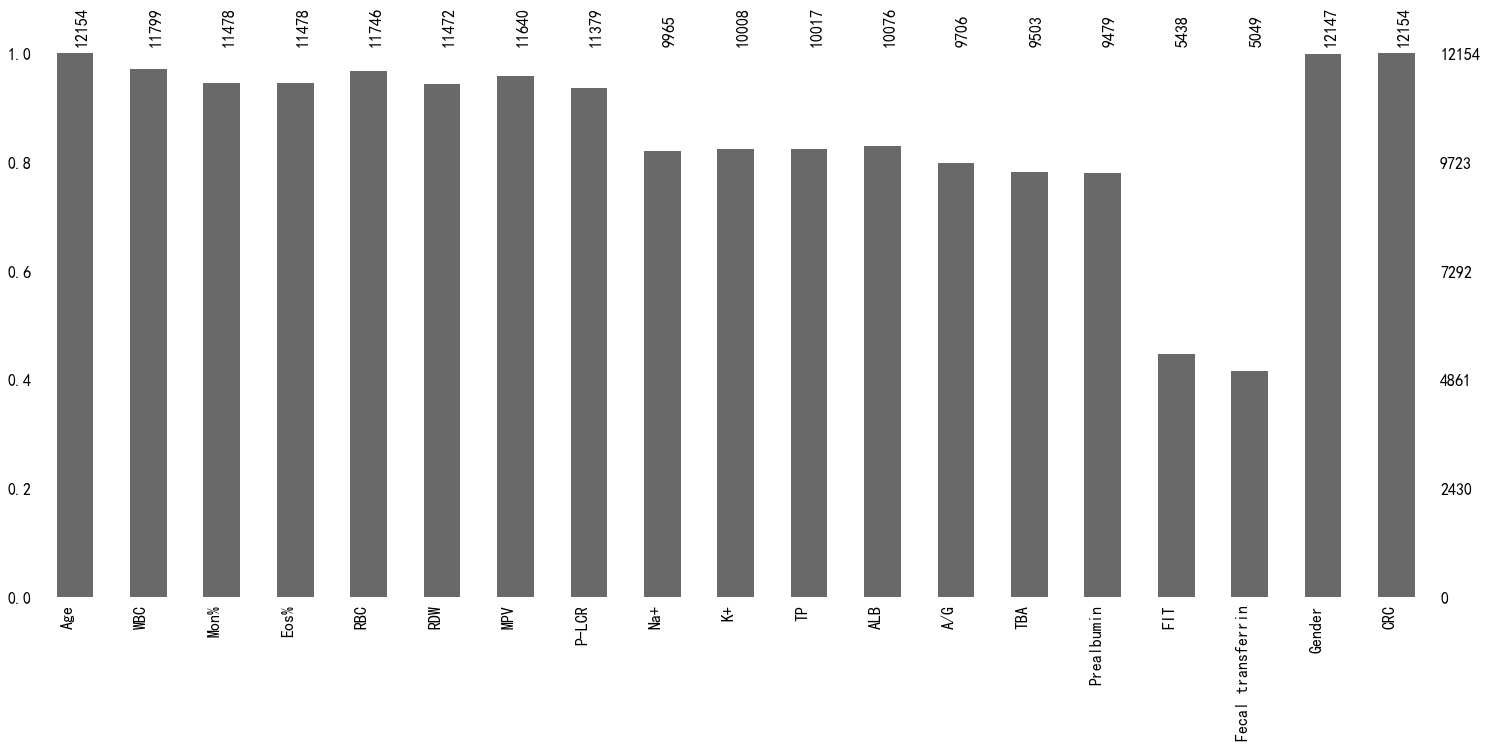

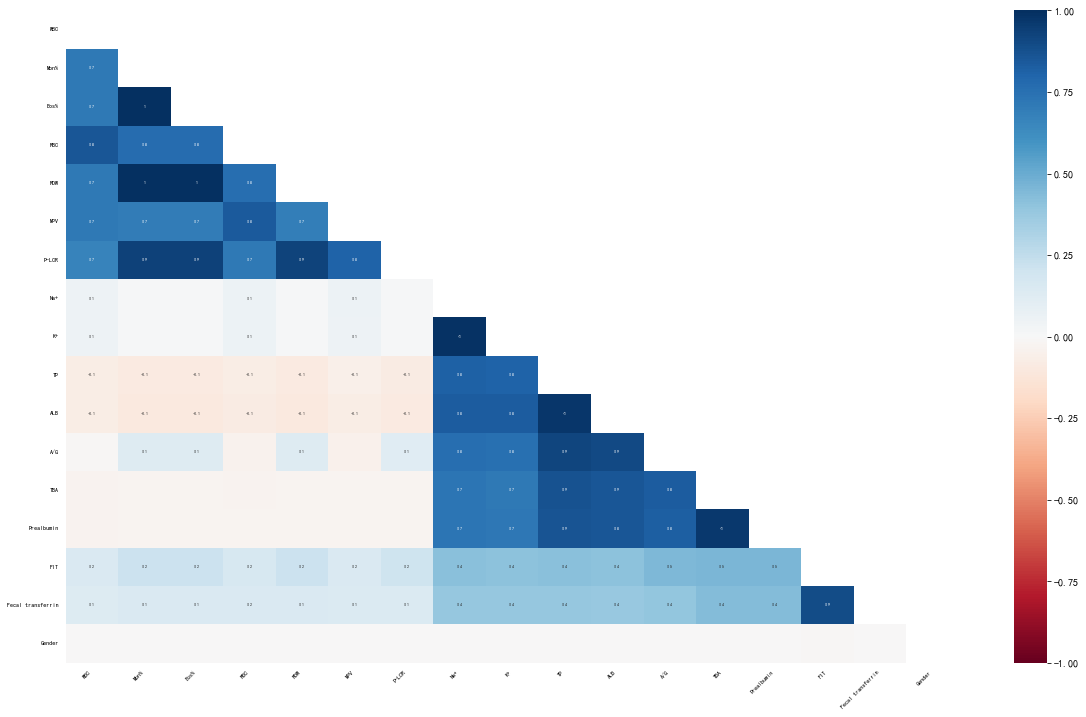

In [429]:
### missingno graph
import missingno as msno
from pylab import mpl
# 设置显示中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


df = pd.DataFrame()
for i in range(len(required_CN_name)):
    df.insert(loc=len(df.columns),column=required_column_name[i],value=std_data[required_CN_name[i]])


msno.bar(df,label_rotation=90)
m=msno.heatmap(df,fontsize=6)
m

In [109]:
### Spilt prospective data
pros_y = np.array(pros_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
pros_X = pros_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(pros_X, pros_y, test_size=test_size, random_state= 42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

scaler = StandardScaler()
pros_X = scaler.fit_transform(pros_X).astype(np.float32)

In [56]:
a,b=BNN_algo(X,pros_X,y,pros_y)
a,b

  0%|          | 0/2001 [00:00<?, ?it/s]

([0.8160276452196807,
  0.7557739394682739,
  0.8238350580243616,
  0.6575809199318569,
  0.853966959004691,
  0.5188172043010753,
  0.9123992155153628,
  11.23003696600795],
 array([[1, 1, 1, ..., 0, 1, 1],
        [1, 0, 0, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1]], dtype=int64))

In [58]:
c,d=XGboostAlgo(X,pros_X,y,pros_y)
c,d

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:26:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


([0.8196478525588283,
  0.762066413811243,
  0.8273617159334028,
  0.6682282793867121,
  0.855904548235774,
  0.5261569416498993,
  0.9150675970344527,
  11.963563172339734],
 array([[0.3379311 , 0.6620689 ],
        [0.29740912, 0.7025909 ],
        [0.36864597, 0.63135403],
        ...,
        [0.59506345, 0.40493652],
        [0.819484  , 0.18051597],
        [0.77395   , 0.22605   ]], dtype=float32))

In [110]:
balance_data = pros_data.copy()
for i in balance_data.index:
    if balance_data["癌"].loc[i]==0: 
        if np.random.rand()>0.4:
            balance_data.drop(i,axis=0,inplace=True)
balance_data.reset_index(inplace=True)
balance_data.drop("index",axis=1,inplace=True)

FIT_y = np.array(balance_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
FIT_X = balance_data.drop(['癌'], axis=1)

scaler = StandardScaler()
FIT_X = scaler.fit_transform(FIT_X).astype(np.float32)

In [111]:
e,f=FOBAlgo(X,FIT_X,y,FIT_y)
e,f

[20:56:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


([0.7415535206820335,
  0.6727574406504538,
  0.7159721404124341,
  0.4067291311754685,
  0.9387857501254391,
  0.7964970809007507,
  0.7287244401168452,
  10.513957374695492],
 array([[0.74110293, 0.25889704],
        [0.24479365, 0.75520635],
        [0.74110293, 0.25889704],
        ...,
        [0.74110293, 0.25889704],
        [0.74110293, 0.25889704],
        [0.74110293, 0.25889704]], dtype=float32))

In [113]:
uncertainty = np.std(b,axis=1)
is_confident = uncertainty < 0.3 

conf_pros_data = pros_data[is_confident]
conf_pros_y = np.array(conf_pros_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
conf_pros_X = conf_pros_data.drop(['癌'], axis=1)
conf_pros_X = scaler.fit_transform(conf_pros_X).astype(np.float32)

g,h=BNN_algo(X,conf_pros_X,y,conf_pros_y)
g,h

  0%|          | 0/2001 [00:00<?, ?it/s]

([0.9230076542098155,
  0.8222997982928584,
  0.9230076542098155,
  0.6885245901639344,
  0.9560750064217827,
  0.6885245901639344,
  0.9560750064217827,
  48.11449676823638],
 array([[0, 1, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [135]:
g,h=BNN_algo(X_train,X_test,y_train,y_test)
g,h

  0%|          | 0/2001 [00:00<?, ?it/s]

([0.8523241464417936,
  0.7135012824515072,
  0.8419223923192645,
  0.48155737704918034,
  0.9454451878538342,
  0.6891495601173021,
  0.8789473684210526,
  16.09721082854799],
 array([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int64))

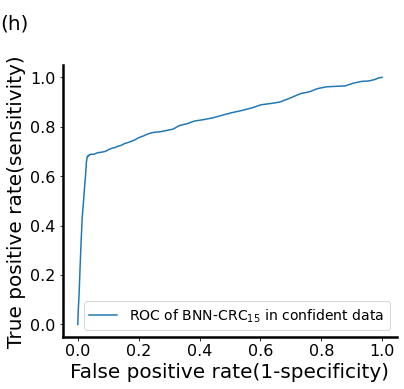

In [115]:
#Fig5B,Fig8B
fpr_1, tpr_1, thresholds = metrics.roc_curve(pros_y, b.mean(1)) #BNN
fpr_2, tpr_2, thresholds = metrics.roc_curve(pros_y, d[:,1]) #XGBoost
fpr_3, tpr_3, thresholds = metrics.roc_curve(FIT_y, f[:,1]) #FIT
fpr_4, tpr_4, thresholds = metrics.roc_curve(conf_pros_y, h.mean(1)) #confident BNN

#roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#plt.plot(fpr_3,tpr_3)


fi, ax= plt.subplots(figsize = (6, 5))
#fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN-CRC$_{15}$")
#fig=plt.plot(fpr_2,tpr_2,label="ROC of XGboost")
#fig=plt.plot(fpr_3,tpr_3,label="ROC of FIT")
fig=plt.plot(fpr_4,tpr_4,label="ROC of BNN-CRC$_{15}$ in confident data ")

# 设置Axes的标题
#ax.set_title('ROC curve compare')
#ax.set_title('ROC of confident data using BNN-CRC$_{15}$')
ax.set_xlabel("False positive rate(1-specificity)",fontsize=20)
ax.set_ylabel("True positive rate(sensitivity)",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=14)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('(h)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig8B.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [67]:
### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

old_a,old_b = BNN_algo(X_train,X_test,y_train,y_test)
is_confident = (np.std(old_b,axis=1)<0.3)
y_test[is_confident],old_b.mean(1)[is_confident]

  0%|          | 0/2001 [00:00<?, ?it/s]

(array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([0.        , 0.95049505, 0.03960396, ..., 0.01980198, 0.        ,
        0.03960396]))

In [72]:
###Rerserve 
pros_y = np.array(pros_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
pros_X = pros_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(pros_X, pros_y, test_size=test_size, random_state= 42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

scaler = StandardScaler()
pros_X = scaler.fit_transform(pros_X).astype(np.float32)

g,h=BNN_algo(X_train,X_test,y_train,y_test)

prob_true_conf,prob_pred_conf = calibration_curve(y_test, h.mean(1), n_bins=10,strategy="quantile")

  0%|          | 0/2001 [00:00<?, ?it/s]

In [74]:
prob_true_conf,prob_pred_conf = calibration_curve(y_test, h.mean(1), n_bins=10,strategy="quantile")

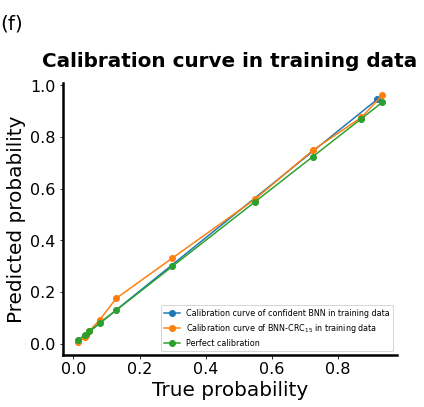

In [104]:
# Calibration,Fig9

from sklearn.calibration import calibration_curve

#simplified BNN
prob_true, prob_pred = calibration_curve(pros_y, b.mean(1), n_bins=10,strategy="uniform")
#prob_true_old, prob_pred_old = calibration_curve(y_test, old_b.mean(1), n_bins=10,strategy="quantile")

#confident data 
#prob_true_conf,prob_pred_conf = calibration_curve(conf_pros_y, h.mean(1), n_bins=10,strategy="uniform")
#prob_true_conf_old, prob_pred_conf_old = calibration_curve(y_test[is_confident], old_b.mean(1)[is_confident], n_bins=10,strategy="uniform")




f, ax= plt.subplots(figsize = (6, 5))


fig=plt.plot(prob_true_conf_old,prob_pred_conf_old,label="Calibration curve of confident BNN in training data",marker="o")
fig=plt.plot(prob_true_old,prob_pred_old,label="Calibration curve of BNN-CRC$_{15}$ in training data",marker="o")
fig=plt.plot(prob_true_old,prob_true_old,label="Perfect calibration",marker="o")

#fig=plt.plot(prob_true_conf,prob_pred_conf,label="Calibration curve of confident BNN in prospective data",marker="o")
#fig=plt.plot(prob_true,prob_pred,label="Calibration curve of BNN-CRC$_{15}$ in prospective data",marker="o")
#fig=plt.plot(prob_true,prob_true,label="Perfect calibration",marker="o")


ax.set_title('Calibration curve in training data',fontsize=20,fontweight="bold",pad=16)
ax.set_xlabel("True probability",fontsize=20)
ax.set_ylabel("Predicted probability",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=8,loc=4)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('(f)', xy=(1, 1), xytext=(0, 1.05),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig9A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [112]:
def HL_test(Og,Eg,Ng):
    HL=0
    assert len(Og)==len(Eg)
    for i in range(len(Og)):
        HL+=min(100,(Og[i]-Eg[i])**2)/Eg[i]/max(0.1,1-Eg[i]/Ng)
        print(min(100,(Og[i]-Eg[i])**2)/Eg[i]/max(0.1,1-Eg[i]/Ng))
        
        #HL+= ((Og[i]-Eg[i])**2)/Eg[i]/(1-Eg[i]/Ng)
        #print (((Og[i]-Eg[i])**2)/Eg[i]/(1-Eg[i]/Ng))
    return HL

In [129]:
### HL_test 
#BNN
#prob_true, prob_pred_BNN = calibration_curve(pros_y, b.mean(1), n_bins=10,strategy="uniform") #new
#prob_true, prob_pred_BNN = calibration_curve(y_test, old_b.mean(1), n_bins=10,strategy="uniform") #old

#confident
#prob_true, prob_pred_BNN = calibration_curve(conf_pros_y, h.mean(1), n_bins=10,strategy="uniform") #new
prob_true, prob_pred_BNN = calibration_curve(y_test, h.mean(1), n_bins=2,strategy="uniform")
#prob_true, prob_pred_BNN = calibration_curve(y_test[is_confident], old_b.mean(1)[is_confident], n_bins=10,strategy="uniform") #old


Eg=[]
Og=[]

#Ng=int(len(pros_y)/10) #new BNN
#Ng=int(len(y_test)/10) #old BNN
#Ng=int(len(h.mean(1))/10) #new confident 
Ng=int(len(y_test)/10)
#Ng=int(len(old_b.mean(1)[is_confident])/10) #old confident 


for i in range(len(prob_true)):
    Og.append(int(prob_true[i]*Ng))
    Eg.append(int(prob_pred_BNN[i]*Ng))

H=HL_test(Og,Eg,Ng)
#scipy.stats.chisquare()
P_value = 1-scipy.stats.chi2.cdf(x=H,df=1)
H,P_value

0.7996709173179762
2.0239880059970012


(2.8236589233149774, 0.09288444743486146)

In [115]:
len(y_test)

2431

### Test Hyperparameter

In [21]:
### define algorithms
h1_layer = [50,100,200]
h2_layer = [None,50,100]


### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)

#scaler = StandardScaler()
#X = scaler.fit_transform(X).astype(np.float32)
test_size = 0.2
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1).astype(np.float32)
X_test_1 = scaler.transform(X_test_1).astype(np.float32)


result = [];

for i in h1_layer:
    for j in h2_layer:
        def BNN_algo(X_train,X_test,y_train,y_test):
            model = Model(d_in=X_train.shape[1], h1=i, h2=j)
            guide = AutoDiagonalNormal(model)
            optim = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(model, guide, optim, loss=Trace_ELBO())

            pyro.clear_param_store()
            bar = trange(2001)
            x_torch = torch.from_numpy(X_train).float()
            y_torch = torch.from_numpy(y_train).float()
            for epoch in bar:
                loss = svi.step(x_torch, y_torch)
                bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')
        
            num_samples = 101
            predictive = Predictive(model, guide=guide, num_samples=num_samples)
            preds = predictive(torch.from_numpy(X_test).float())
            y_pred = preds['obs'].T.detach().numpy()
            uncertainty = np.std(y_pred, axis=1)
            y_pred_class = np.median(y_pred,axis=1)
            is_confident = uncertainty < 0.3
            result = show_result(y_test,y_pred_class)
    
            return result,y_pred

        para_result, para_predict =BNN_algo(X_train_1, X_test_1, y_train_1, y_test_1) 
        result.append(para_result)
 

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [24]:
pd.DataFrame(result).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Hyperparameter.xlsx")

### Show confident, graph

In [121]:
label_data = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Prospective cohort\Attempt4\chosen_data.xlsx",index_col=0)

In [86]:
#result_1, predict_1 = BNN_algo(X, pros_X, y, pros_y) 
result_1, predict_1 = BNN_algo(X, X, y, y) 

  0%|          | 0/2001 [00:00<?, ?it/s]

In [87]:
conf_nonCRC=predict_1.sum(axis=1)<10

bool1 = [predict_1.sum(axis=1)>=10]
bool2 = [predict_1.sum(axis=1)<51]
unconf_nonCRC= []
for i in range(len(bool1[0])):
    unconf_nonCRC.append(bool(bool1[0][i]*bool2[0][i]))
unconf_nonCRC = np.array(unconf_nonCRC)

bool4 = [predict_1.sum(axis=1)>=51]
bool3 = [predict_1.sum(axis=1)<91]    
unconf_CRC= []
for i in range(len(bool3[0])):
    unconf_CRC.append(bool(bool3[0][i]*bool4[0][i]))
unconf_CRC = np.array(unconf_CRC)



conf_CRC=predict_1.sum(axis=1)>=91

In [88]:
simplified_merged

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,A/G,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,9.5,21.9,141.0,4.5,69.0,39.0,1.30,5.1,147.00000,0,1,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,10.4,28.0,142.0,4.0,72.0,47.0,1.88,6.5,192.00000,0,1,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,9.2,17.6,136.0,4.2,70.0,43.0,1.59,2.2,210.00000,0,1,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,9.6,21.6,146.0,4.1,74.0,45.0,1.55,10.1,225.49881,0,1,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,9.2,17.7,132.0,3.8,63.0,37.0,1.42,2.3,199.00000,0,1,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,8.2,3.1,4.24,12.0,10.5,28.6,143.0,4.1,62.0,37.0,1.48,2.8,257.00000,0,1,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,10.2,25.5,143.0,4.3,62.0,36.0,1.38,2.3,228.00000,0,1,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,13.1,50.4,142.0,3.9,63.0,40.0,1.74,2.2,213.00000,0,1,0,1,1.00000,0
27909,52,6.72,7.3,3.1,4.33,12.6,10.3,27.3,139.0,4.1,80.0,49.0,1.58,20.1,310.00000,0,0,0,0,0.00000,0


In [89]:
#data1 = label_data[conf_nonCRC]
#data2 = label_data[unconf_nonCRC]
#data3 = label_data[unconf_CRC]
#data4 = label_data[conf_CRC]

data1 = simplified_merged[conf_nonCRC]
data2 = simplified_merged[unconf_nonCRC]
data3 = simplified_merged[unconf_CRC]
data4 = simplified_merged[conf_CRC]

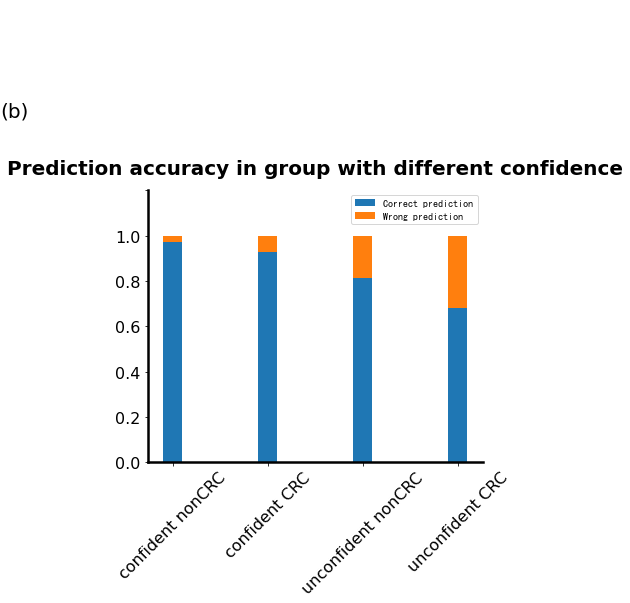

In [105]:
    box_1, box_2, box_3, box_4 = data1["癌"], data2["癌"], data3["癌"], data4["癌"]
    
    ratio_neg_1=box_1.sum()/box_1.count() #因为预测值都是0
    ratio_pos_1=1-box_1.sum()/box_1.count()
    ratio_neg_2=box_2.sum()/box_2.count()
    ratio_pos_2=1-box_2.sum()/box_2.count()
    ratio_pos_3=box_3.sum()/box_3.count() #因为预测值都是0
    ratio_neg_3=1-box_3.sum()/box_3.count()
    ratio_pos_4=box_4.sum()/box_4.count()
    ratio_neg_4=1-box_4.sum()/box_4.count()
    
    fig, ax = plt.subplots(figsize=(6,5))
    plt.title("Prediction accuracy in group with different confidence",fontsize=20,pad=16,fontweight="bold")   #标题，并设定字号大小
    ax.bar(['confident nonCRC','confident CRC','unconfident nonCRC','unconfident CRC'],height=[ratio_pos_1,ratio_pos_4,ratio_pos_2,ratio_pos_3],width=0.2,label="Correct prediction")
    ax.bar(['confident nonCRC','confident CRC','unconfident nonCRC','unconfident CRC'],bottom=[ratio_pos_1,ratio_pos_4,ratio_pos_2,ratio_pos_3],height=[ratio_neg_1,ratio_neg_4,ratio_neg_2,ratio_neg_3],width=0.2,label="Wrong prediction")
    plt.xticks(rotation=45,fontsize=16)
    plt.yticks(ticks=[0.0,0.2,0.4,0.6,0.8,1.0,1.2],labels=[0.0,0.2,0.4,0.6,0.8,1.0,""],fontsize=16)
    plt.legend(prop={'family':'SimHei','size':10},loc=1)#bbox_to_anchor=(0.8, 0.955))
    
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.annotate('(b)', xy=(1, 1), xytext=(0, 1.35),xycoords="figure fraction",fontsize=20)

    plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\SuppFig1.png",dpi=800,bbox_inches='tight',pad_inches=0.2)
    
    #plt.show()
    #plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\box graph\confident\binary graph" +"/" + i+".png")

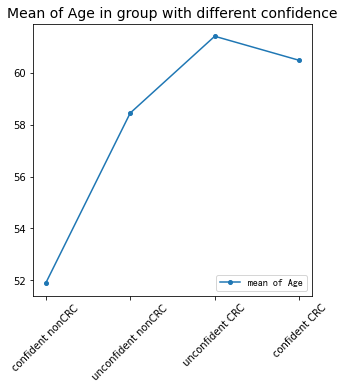

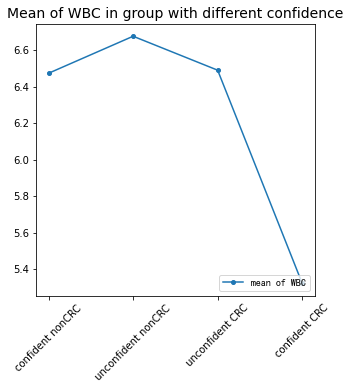

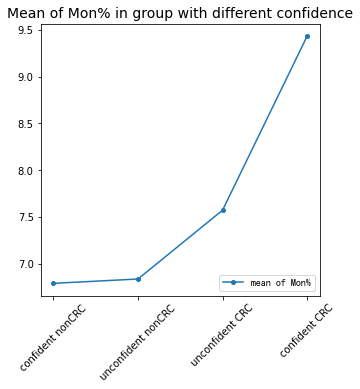

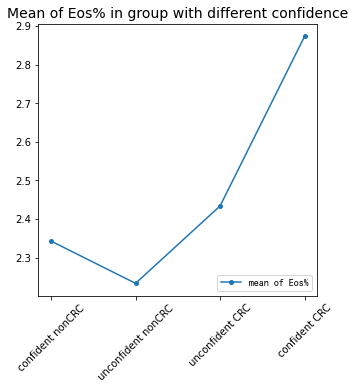

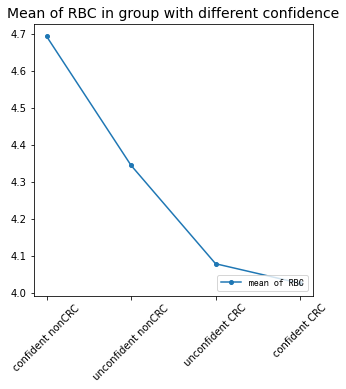

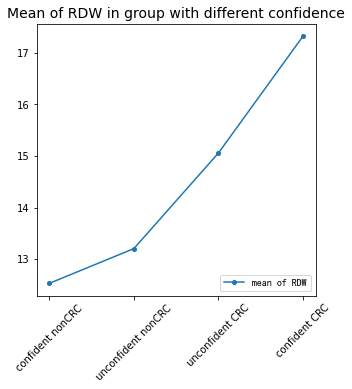

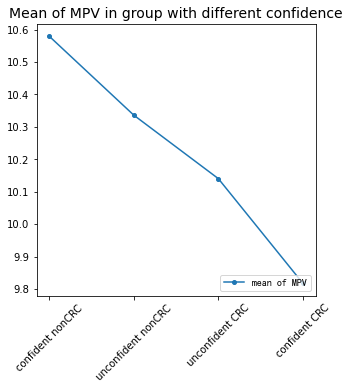

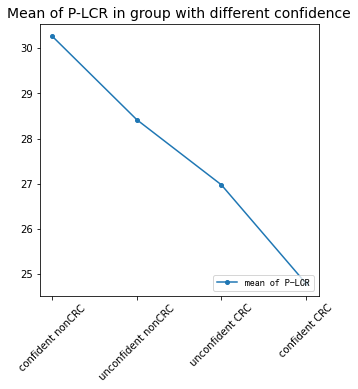

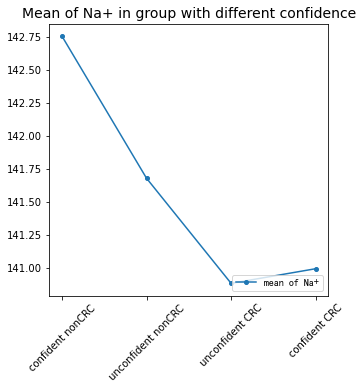

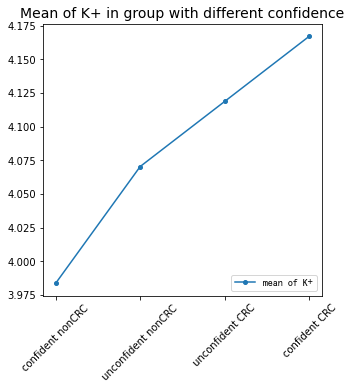

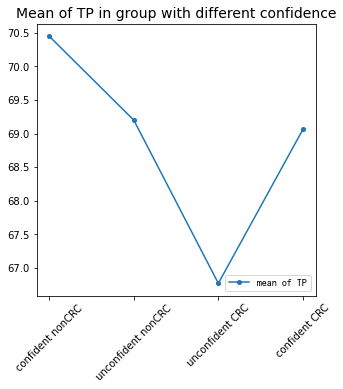

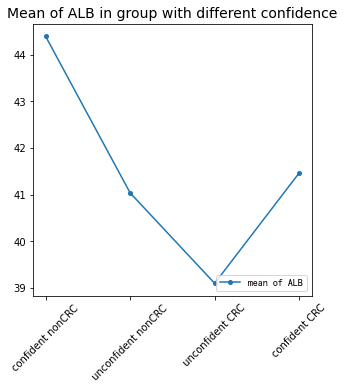

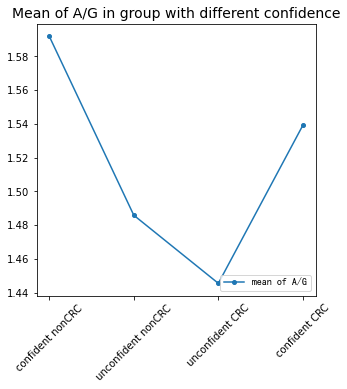

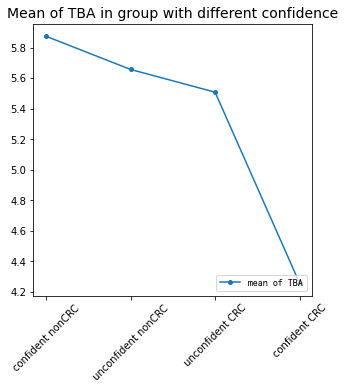

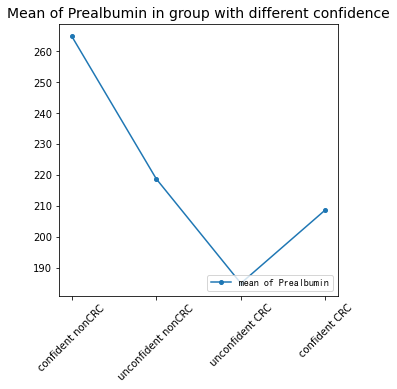

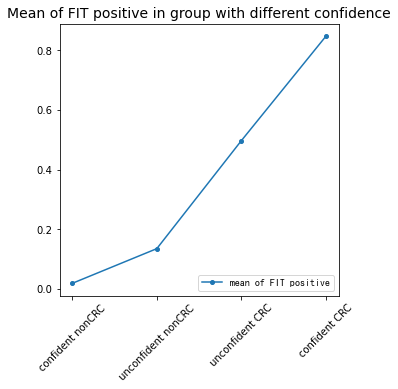

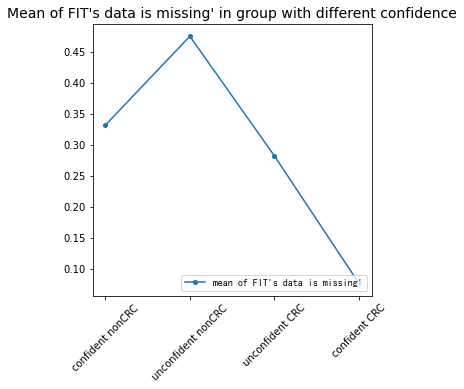

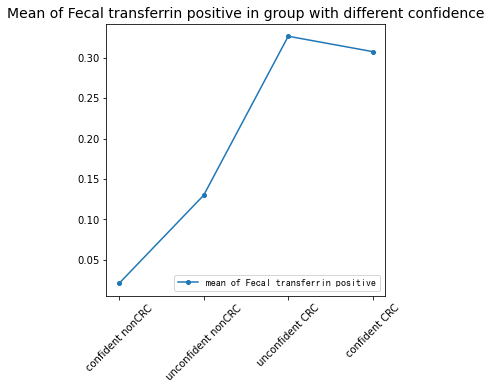

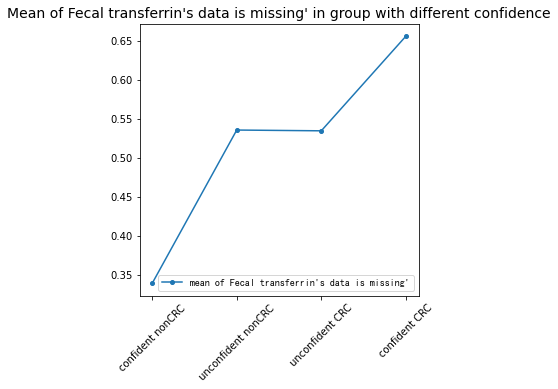

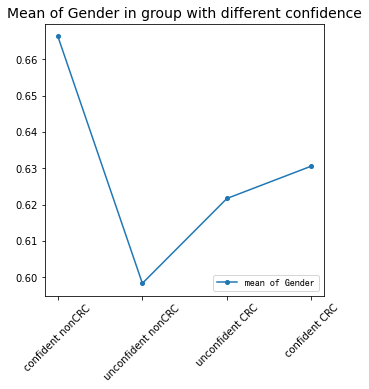

In [204]:
for i in simplified_merged.columns[:-1]:
    
    xtick = ['confident nonCRC','unconfident nonCRC','unconfident CRC','confident CRC']
    ytick = data1[i].mean(),data2[i].mean(),data3[i].mean(),data4[i].mean()

    fig, ax = plt.subplots(figsize=(5,5))
    plt.title("Mean of "+i+" in group with different confidence",fontsize=14)   #标题，并设定字号大小
    plt.plot(xtick,ytick,marker=".",markersize=8,label=str("mean of "+i))
    plt.xticks(rotation=45)

    plt.legend(prop={'family':'SimHei','size':10},loc=4)
    #plt.show()
        
    if i!="A/G":  
        plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\feature mean plot in confidence group" +"/" + i+".png")
    else: 
        plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\feature mean plot in confidence group" +"/" + "A and G ratio"+".png")

### Specified patient of confidence level


In [46]:
### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test = X_test.copy()
original_test = simplified_merged.loc[original_x_test.index]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [47]:
result_1, predict_1 = BNN_algo(X_train, X_test, y_train, y_test)

conf_nonCRC=predict_1.sum(axis=1)<10

bool1 = [predict_1.sum(axis=1)>=45]
bool2 = [predict_1.sum(axis=1)<51]
unconf_nonCRC= []
for i in range(len(bool1[0])):
    unconf_nonCRC.append(bool(bool1[0][i]*bool2[0][i]))
unconf_nonCRC = np.array(unconf_nonCRC)

bool4 = [predict_1.sum(axis=1)>=51]
bool3 = [predict_1.sum(axis=1)<56]    
unconf_CRC= []
for i in range(len(bool3[0])):
    unconf_CRC.append(bool(bool3[0][i]*bool4[0][i]))
unconf_CRC = np.array(unconf_CRC)


conf_CRC=predict_1.sum(axis=1)>=91

original_test["Test Positive"] = predict_1.sum(axis=1)
original_test["Test Negative"] = 101-predict_1.sum(axis=1)
original_test["Certainty"] = np.std(predict_1,axis=1)

  0%|          | 0/2001 [00:00<?, ?it/s]

In [51]:
original_test[conf_nonCRC].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident data\0conf.xlsx")
original_test[conf_CRC].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident data\1conf.xlsx")
original_test[unconf_CRC].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident data\1unconf.xlsx")
original_test[unconf_nonCRC].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident data\0unconf.xlsx")

